### Analyzing Cog Sci abstract data
March 4, 2018

This notebook grabs the cogsci proceedings data and does the following.

###### LSA:
- pre-processing: creates tf-idf representation of each abstract.
- analysis: performs Latent Semantic Analysis (truncated SVD) using gensim for latent space document and term representation.
- clustering: hierarchical clustering, t-SNE, PCA?

###### word2vec:
DONE: gensim automatically takes care of preprocessing here, which is super nice
- skip-gram/cbow pre-processing
- build word2vec model using gensim for word meaning vectors



LATER: build doc2vec model using gensim for doc meaning

All analyses are first done with only cognitive key words for a sparse but cognition-specific model, then it's repeated with all words for a fuller dataset.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import gensim as gs
from sklearn import decomposition, metrics, cluster
import matplotlib.pyplot as plt
import string

### function defs

In [2]:
def corpus_from_list(doc_list, terms_dict=None):
    # transform doc_list, which is a list of strings where each string is a document, into gensim friendly corpus form
    # are you f-ing serious I have to build the corpus feature myself..?
    terms = term_dict.keys()
    corpus_index = [None]*len(doc_list)
    corpus_terms = [None]*len(doc_list)
    for doc_ind, doc in enumerate(doc_list):
        cur_corp_index = []
        cur_corp_terms = []
        for term in terms:
            # use all lower case to search
            t_count = doc.lower().count(term)
            if t_count:
                cur_corp_index.append((term_dict[term], t_count))
                cur_corp_terms.append(term)
                
        corpus_index[doc_ind] = cur_corp_index
        corpus_terms[doc_ind] = cur_corp_terms
    
    return corpus_index, corpus_terms

def terms_similar_to(term_sim, dictionary, query_term='attention', topN=10):
    # querying top N similar words
    if query_term in dictionary.token2id.keys():
        query_ind = dictionary.token2id[query_term]
        print('Freq. | Similarity: Term')
        print('------------------------')
        for i in np.argsort(term_sim[query_ind,:])[::-1][:topN]:
            print('%.3f | %.3f: '%(dictionary.dfs[i]/dictionary.num_docs, term_sim[query_ind,i]) + dictionary.id2token[i])
            
    else:
        print(query_term + ' is not in the dictionary.')


        
def wv_similar_to(word_vec, all_vectors, topN=10):
    # find the top N most similar words in terms of cosine similarity
    cos_sim = metrics.pairwise.cosine_similarity(word_vec.astype('float64').reshape(1,-1), 
                                                 all_vectors.astype('float64')).squeeze()
    top_inds = np.argsort(cos_sim)[::-1][:topN]
    return top_inds, cos_sim[top_inds]


def most_similar_subset(all_vocab, subset_vocab, all_vectors, positive, negative=[], topn=10): 
    # similar to gensim.KeyedVectors.similar_to(), but with a restricted dictionary to search from
    # and can also with any word vectors, like LSA representation
    # so this will do the exact same thing as terms_similar_to() above when given the same dictionary
    
    # this takes long for repeatedly querying big dicts, so have an option for precomputed indices
    if type(subset_vocab[0]) is str:
        # compute only if subset is given in strings
        subset_inds = np.sort([all_vocab.index(t) for t in subset_vocab if t in all_vocab]) 
    else:
        # otherwise, assume it's precomputed indices
        print('Using precomputed subset indices...')
        subset_inds = subset_vocab
        
    query_vec = np.zeros_like(all_vectors[0,:])
    pos_neg = [positive, negative]
    weight=[1,-1]
    for i in range(len(pos_neg)):
        for t in pos_neg[i]:
            if t in all_vocab:
                query_vec = query_vec + weight[i]*all_vectors[all_vocab.index(t),:]
            else:
                print(t+' is not in vocabulary. Discarded.')

    topN_inds, topN_sim = wv_similar_to(query_vec, all_vectors[subset_inds,:], topN=topn)
    return [([all_vocab[i] for i in subset_inds][w], topN_sim[i]) for i,w in enumerate(topN_inds)]

def print_similarity(similarity_list):
    # just a helper function to pretty print the similarity list
    print('----------------\nCosine Similiarty\n---------------')
    for w in similarity_list:
        print('%.4f: '%w[1] + w[0])

In [3]:
# import dictionary (cognitive concept word list)
terms_file = '../data/cogatlas_terms.txt'
terms = pd.read_csv(terms_file, delimiter='\n', names=['Terms'])

# construct as dictionary
# gensim requires dict to be of form {'word':id}, so zip together term list and id numbers
term_dict = dict(zip(terms['Terms'], range(len(terms['Terms'])))) 

# import data as pd dataframe
abstract_file = '../data/cogsci_abstracts.csv'
col_names = ('Year', 'Title', 'Abstract', 'Authors', 'Affiliations', 'URL')
df_cs = pd.read_csv(abstract_file, header=None, names=col_names)
print('%i documents extracted.' %len(df_cs))

6385 documents extracted.


In [4]:
# combine title & abstract of each document and put into list
doc_list = []
for t in range(len(df_cs)):
    if type(df_cs['Abstract'][t]) is not str:
        doc_list.append(df_cs['Title'][t])
    else:
        doc_list.append(df_cs['Title'][t]+'. ' + df_cs['Abstract'][t])    
        
# convert document list into dictionary-words only list, by using the custom dictionary.
# if using the whole corpus to build dictionary, just do 
#     dct = gs.corpora.Dictionary([d.lower() for d in doc_list.lower])
print('Pruning document list for dictionary words only...')
corpus_index, corpus_terms = corpus_from_list(doc_list=doc_list, terms_dict=term_dict)

Pruning document list for dictionary words only...


### Latent Semantic Analysis
https://en.wikipedia.org/wiki/Latent_semantic_analysis#Derivation

###### tf-idf model
Some questions:
- is it necessary to stem the keywords/data?
- how best to handle phrases where sub-phrases are also dict phrases ("memory" in "working memory", "concept" in "conceptual)? (https://stackoverflow.com/questions/4173787/string-exact-match/4173810)

In [5]:
# building tf-idf representation

# use gensim to rebuild dictionary, though now the original dictionary that 
# I build (term_dict) will have different indices than the gensim dict (dct), which
# is fine, just need to be careful with indexing and not use the original dict
dct = gs.corpora.Dictionary(corpus_terms)
print(dct)
corpus = [dct.doc2bow(line) for line in corpus_terms]
model = gs.models.TfidfModel(corpus, id2word=dct)  # fit model
corpus_tfidf = [model[c] for c in corpus]

Dictionary(516 unique tokens: ['concept', 'focus', 'goal', 'learning', 'search']...)


In [6]:
# train LSA model using tfidf
model = gs.models.lsimodel.LsiModel(corpus_tfidf, id2word=dct, num_topics=20)
model.print_topics(20)
# put topic vectors into a pandas df
df = pd.DataFrame([[t[0]+" %.3f" %t[1] for t in model.show_topic(i)] for i in range(model.num_topics)])
#df
index = gs.similarities.MatrixSimilarity(model[corpus_tfidf])

### Fun little query to show document similarity
Looks like document similarity is pretty good! Though this wasn't even what I wanted to get at...

In [7]:
print_abstr=False
doc_num = 100#np.random.randint(len(corpus_tfidf))
topN = 5
doc_sim = sorted(enumerate(index[model[corpus_tfidf[doc_num]]]), key=lambda item: -item[1])
print(doc_num)
for i in range(topN+1):
    print('---%i---'%i)
    print(df_cs['Title'][doc_sim[i][0]])
    if print_abstr: print(df_cs['Abstract'][doc_sim[i][0]])

100
---0---
Children’s social referencing reflects sensitivity to graded uncertainty
---1---
What role do you play in group activity? Objective evaluation through third parties
---2---
Social and Environmental Contributors to Infant Word Learning
---3---
Narrowing of the Cone-of-Direct Gaze Through Reinforcement Learning
---4---
Online Processing of Speech and Social Information in Early Word Learning
---5---
How does this thing work? Evaluating computational models of intervention-based causal learning


In [8]:
# word frequency
for t in np.argsort([dct.dfs[t] for t in range(len(dct.dfs))])[::-1]:    
    print('%.3f: '%(dct.dfs[t]/dct.num_docs) + dct.id2token[t])

0.257: learning
0.228: search
0.215: action
0.184: language
0.151: logic
0.126: knowledge
0.125: concept
0.121: memory
0.117: context
0.101: decision
0.089: attention
0.082: reasoning
0.080: judgment
0.079: focus
0.075: lying
0.073: inference
0.073: perception
0.071: meaning
0.061: goal
0.058: movement
0.053: recognition
0.047: reading
0.046: skill
0.044: belief
0.043: strategy
0.042: rule
0.038: emotion
0.038: association
0.037: communication
0.036: categorization
0.032: insight
0.032: working memory
0.032: thought
0.032: activation
0.028: recall
0.028: strength
0.026: resource
0.026: priming
0.026: intention
0.026: manipulation
0.025: decision making
0.025: problem solving
0.025: generalization
0.024: uncertainty
0.023: gaze
0.022: integration
0.021: conversation
0.021: effort
0.021: encoding
0.020: retrieval
0.020: detection
0.020: fixation
0.019: category learning
0.018: valence
0.018: metaphor
0.017: risk
0.017: coordination
0.016: discourse
0.016: eating
0.016: interference
0.016

Term Similarity Matrix: (516, 516)


Text(0.5,1,'Term Cosine Similarity')

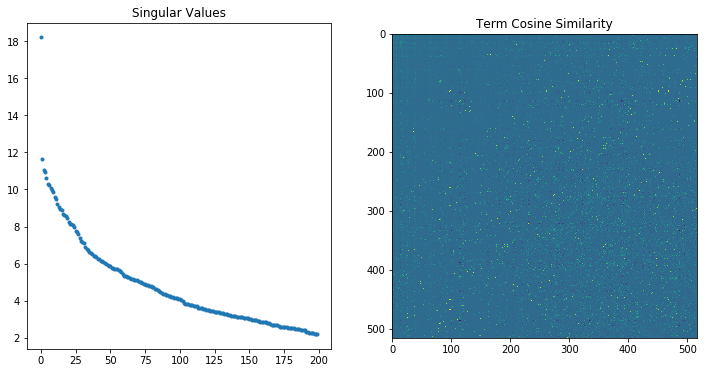

In [9]:
# scipy SVD to compute term similarity
num_comp = 200

# get dense tfidf matrix to do SVD in scipy to compare word similarities
mat_tfidf = gs.matutils.corpus2dense(corpus_tfidf, len(dct.dfs))
TSVD = decomposition.TruncatedSVD(n_components=num_comp)
TSVD.fit_transform(mat_tfidf.T)
U = TSVD.components_
TSVD.fit_transform(mat_tfidf)
V = TSVD.components_
S = np.diag(TSVD.singular_values_)

# get transformed word vectors
# QUESTION: why multiply by the singular values here?
# U is an unitary matrix (N_t x k), therefore >np.matmul(U,U.T) == metrics.pairwise.cosine_similarity(U)
#    columns of U are the bases of the projected space, and multiplying by S gives the weighted length?
#
# X_star is the low dimensional approximation of X, so X_star*X_star.T gives the covariance matrix of 
#    the low-d term vectors. U is the "term" basis matrix in the low-D projection space, U*S gives the actual 
#    projected length of each term vector in the low-D space.
# S stretches the low-D basis (k space) differently for each k, i.e. it emphasises some dimensions
# conceptually, if one dimension is way more important than the others, than scaling it more will
# emphasize differences/similiarities along that axis only
t_star = np.matmul(S,U).T

# word similarity from raw tfidf matrix
term_sim_raw = metrics.pairwise.cosine_similarity(mat_tfidf) 
# word similarity from LSA transformed matrix
term_sim_LSA = metrics.pairwise.cosine_similarity(t_star)
print('Term Similarity Matrix: (%i, %i)'%term_sim_LSA.shape)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(TSVD.singular_values_, '.')
plt.title('Singular Values')
plt.subplot(1,2,2)
plt.imshow(term_sim_LSA - sp.eye(term_sim_LSA.shape[0]))
plt.title('Term Cosine Similarity')

In [10]:
terms_similar_to(term_sim_LSA, dct, 'working memory', 20)

Freq. | Similarity: Term
------------------------
0.032 | 1.000: working memory
0.002 | 0.617: visual working memory
0.002 | 0.599: spatial working memory
0.001 | 0.559: phonological loop
0.000 | 0.545: gestalt grouping
0.000 | 0.499: phonological working memory
0.000 | 0.493: central executive
0.000 | 0.478: interference control
0.121 | 0.441: memory
0.000 | 0.426: interference resolution
0.000 | 0.394: working memory updating
0.001 | 0.379: cognitive training
0.001 | 0.341: response selection
0.001 | 0.340: change blindness
0.000 | 0.337: semantic working memory
0.000 | 0.287: attentional state
0.001 | 0.285: phonological awareness
0.001 | 0.274: fluid intelligence
0.000 | 0.265: contingency learning
0.000 | 0.261: goal management


In [11]:
LSA_terms = [t for t in dct.id2token.values()]
most_similar_subset(LSA_terms, LSA_terms, t_star, ['working memory'], topn=20)

[('working memory', 0.9999999999999998),
 ('visual working memory', 0.6171730334983372),
 ('spatial working memory', 0.598684400484096),
 ('phonological loop', 0.5591836738466622),
 ('gestalt grouping', 0.5448699654460593),
 ('phonological working memory', 0.49923555620393134),
 ('central executive', 0.493181252938077),
 ('interference control', 0.4784686116631925),
 ('memory', 0.4407875468648538),
 ('interference resolution', 0.4260041370997508),
 ('working memory updating', 0.3938798242837216),
 ('cognitive training', 0.3793850732640781),
 ('response selection', 0.34104068682675537),
 ('change blindness', 0.34034929410212983),
 ('semantic working memory', 0.3374964248818626),
 ('attentional state', 0.2866532174010745),
 ('phonological awareness', 0.28538327916261713),
 ('fluid intelligence', 0.2738814437839995),
 ('contingency learning', 0.2645633506041193),
 ('goal management', 0.2606574150598996)]

### Clustering

[13, 48, 32, 12, 14, 30, 10, 11, 11, 24, 288, 23]


/Users/rdgao/anaconda3/lib/python3.6/site-packages/scipy/sparse/csgraph/_laplacian.py:72: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, int)


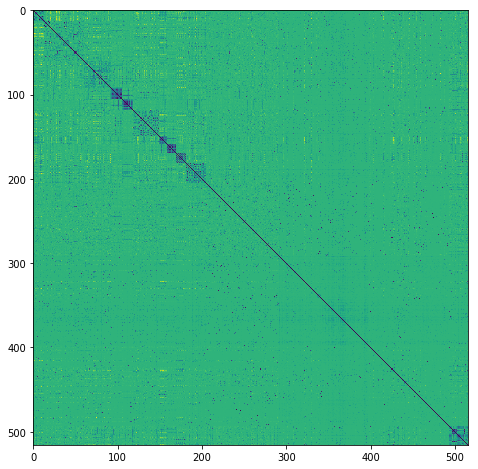

In [12]:
# because transformed word vectors can be negative, apply heat kernel:
#      similarity = np.exp(-beta * distance / distance.std())
beta=0.001
n_clusters = 12
term_dist_LSA = 1.-term_sim_LSA
clu = cluster.SpectralClustering(n_clusters=n_clusters, affinity='precomputed', assign_labels='kmeans')

clu.fit(np.exp(-(beta/term_dist_LSA.std())*term_dist_LSA))
clu_label = clu.labels_

#clu_label = clu.fit(np.exp(-beta * (1.-term_sim_LSA)/(1.-term_sim_LSA).std()))
clu_inds = np.argsort(clu_label)
plt.figure(figsize=(8,8))
plt.imshow(term_dist_LSA[clu_inds,:][:,clu_inds])
print([len(np.where(clu_label==c)[0]) for c in range(n_clusters)])
clustered_terms = [[dct.id2token[i] for i in np.where(clu_label==query_clu)[0]] for query_clu in range(n_clusters)]

In [13]:
pd.DataFrame([t[:10] for t in clustered_terms], index=['Clu%i'%i for i in range(n_clusters)])

,0,1,2,3,4,5,6,7,8,9
Clu0,memory trace,rehearsal,cognitive effort,auditory imagery,altruism,audition,conditional reasoning,deductive reasoning,melody,serial search
Clu1,intelligence,social intelligence,logical reasoning,imagery,mental imagery,social inference,visual memory,visual perception,planning,analogical inference
Clu2,implicit knowledge,attention,curiosity,motor program,centration,perceptual skill,word comprehension,attentional resources,metacomprehension,memory retrieval
Clu3,conflict detection,inhibition,skepticism,inhibition of return,response conflict,excitation,response inhibition,interrogative,feature integration,response execution
Clu4,detection,abductive reasoning,visual angle,attentional blink,inattention,inattentional blindness,global precedence,motion detection,object detection,object-based attention
Clu5,recognition,cognitive control,retrieval,intonation,syntactic processing,lexical access,contextual knowledge,attentional bias,lexical retrieval,confidence judgment
Clu6,memory decay,pronunciation,dyslexia,implicit memory,word pronunciation,phonological awareness,phonological processing,serial learning,auditory feedback,central executive
Clu7,explicit memory,consolidation,memory consolidation,sleep,proactive interference,retroactive interference,reconsolidation,dream,delusion,fatigue
Clu8,intertemporal choice,deliberation,stereotypes,emotional expression,fear,worldview,sadness,happiness,shame,capacity limitation
Clu9,memory,working memory,maintenance,processing capacity,sensory memory,response bias,visual working memory,forgetting,prospective memory,active maintenance


# word2vec
gensim word2vec takes list of sentences as input.

Questions:
- how best to combine phrases?
- should words be stemmed?

In [14]:
def terms_to_phrases(sentence_list_orig, terms_orig, merge_char=' '):
    # takes a sentence list (prepped for word2vec) and find multi-word phrases from
    # a dictionary (terms_orig) and merge them into single terms
    sentence_list = [s for s in sentence_list_orig]
    terms = [t for t in terms_orig]
    
    # takes multi-word terms and merge them into phrases, and change the sentence_list accordingly
    for t_ind, t in enumerate(terms):
        t_split = t.split(sep=' ')
        # if it's a multi-word term
        if len(t_split)>1:
            terms[t_ind] = merge_char.join(t_split)
            print(terms[t_ind])
            for s in sentence_list:
                # go through all the sentences to find and combine that phrase
                for i,w in enumerate(s):
                    if w == t_split[0] and s[i:i+len(t_split)]==t_split:
                        s[i:i+len(t_split)] = [merge_char.join(t_split)]

    return sentence_list, terms

In [15]:
# combine title & abstract of each document and put into list
exclude = set(string.punctuation) - {'-'} # don't discard dashes
sentence_list = []
for t in range(len(df_cs)):
    sentence_list.append(df_cs['Title'][t])
    # check if the abstract is empty
    if type(df_cs['Abstract'][t]) is str:
        sentence_list = sentence_list + df_cs['Abstract'][t].split('.')

# get rid of blanks, punctuations, and convert sentences into lists of words
sentence_list = [''.join(ch for ch in s if ch not in exclude).lower().split() for s in sentence_list if s is not '']

In [16]:
# loop over again to combine words that are phrases in the cognitive terms
sentence_list, terms_merged = terms_to_phrases(sentence_list, terms['Terms'], merge_char='-')

abductive-reasoning
abstract-analogy
abstract-knowledge
acoustic-coding
acoustic-encoding
acoustic-phonetic-processing
acoustic-processing
action-initiation
action-perception
activation-level
active-maintenance
active-recall
active-retrieval
adaptive-control
affect-perception
affect-recognition
altruistic-motivation
amodal-representation
analog-representation
analogical-encoding
analogical-inference
analogical-problem-solving
analogical-reasoning
analogical-transfer
animacy-decision
animacy-perception
antisocial-personality
apparent-motion
appetitive-motivation
arithmetic-processing
arousal-(emotion)
arousal-(physical)
articulatory-loop
articulatory-planning
articulatory-rehearsal
association-learning
associative-priming
attended-channel
attended-stimulus
attention-capacity
attention-shift
attention-shifting
attention-span
attentional-bias
attentional-blink
attentional-effort
attentional-focusing
attentional-resources
attentional-state
audiovisual-perception
auditory-arithmetic-process

rehearsal-loop
reinforcement-learning
relational-comparison
relational-learning
remote-memory
repetition-priming
repressed-memory
resistance-to-distractor-inference
resource-limit
resource-sharing
response-bias
response-conflict
response-execution
response-inhibition
response-priming
response-selection
restricted-behavior
retrieval-cue
retroactive-interference
reward-anticipation
reward-learning
reward-processing
reward-valuation
right-finger-response-execution
right-hand-response-execution
right-toe-response-execution
risk-aversion
risk-aversion
risk-processing
risk-seeking
route-knowledge
rule-learning
selective-attention
selective-control
self-control
self-knowledge
self-monitoring
self-talk
semantic-categorization
semantic-category
semantic-information
semantic-knowledge
semantic-memory
semantic-network
semantic-priming
semantic-processing
semantic-working-memory
sense-of-body-ownership
sense-of-ownership
sensitivity-to-change
sensory-defensiveness
sensory-memory
sentence-comprehen

In [17]:
len(terms_merged)

815

In [18]:
# get gensim model
model = gs.models.Word2Vec(sentence_list, min_count=2, size=100, window=10, sg=1)
w2v_vocab = model.wv.index2word # get the vocab of word2vec representation

In [19]:
print_similarity(model.wv.most_similar(positive=['learning', 'categorization'], topn=20))
print_similarity(model.wv.most_similar(positive=['learning'], negative=['categorization'], topn=20))

#print_similarity(model.wv.most_similar(positive=['dopamine'], negative=['learning'], topn=20))
#print_similarity(model.wv.most_similar(positive=['dopamine'], negative=['brain'], topn=20))

----------------
Cosine Similiarty
---------------
0.8374: category-learning
0.7837: observational
0.7797: interleaving
0.7721: concept-learning
0.7635: generalization
0.7469: formation
0.7413: hypothesis-testing
0.7403: prototype
0.7371: information-integration
0.7336: semi-supervised
0.7294: selective-attention
0.7286: impose
0.7265: rule-learning
0.7258: error-driven
0.7253: nonadjacent
0.7250: classification
0.7247: regularization
0.7245: induction
0.7223: attentional-bias
0.7220: neighbor
----------------
Cosine Similiarty
---------------
0.2604: training
0.2533: learn
0.2418: intervention
0.2398: teaching
0.2349: feedback
0.2168: tutoring
0.2132: instruction
0.2120: learners
0.2119: intelligent
0.2090: program
0.1941: students’
0.1874: lesson
0.1810: student
0.1756: peer
0.1734: learner
0.1679: students
0.1659: tutor
0.1650: receiving
0.1648: productive
0.1630: college


### Search for similarity 
###### In whole dictionary and cognitive terms-only.
below includes a custom most_similar function that restricts the search in a provided dictionary, in this case, the subset of cognitive terms

note that the custom function can in theory be applied to LSA word vectors as well

In [20]:
topn=10
positive = ['learning']
negative = []
negative = ['categorization']

print('\n--- Search in whole corpus: ---')
#print_similarity(model.wv.most_similar(positive=positive, negative=negative, topn=topn))
pd.DataFrame(model.wv.most_similar(positive=positive, negative=negative, topn=topn))

# print('\n--- Search only the cognitive terms: ---')
# print_similarity(most_similar_subset(model.wv.index2word,terms['Terms'],model.wv.vectors,positive,negative,topn))


--- Search in whole corpus: ---


,0,1
0,training,0.260417
1,learn,0.253287
2,intervention,0.241828
3,teaching,0.239764
4,feedback,0.234852
5,tutoring,0.216761
6,instruction,0.213210
7,learners,0.211983
8,intelligent,0.211900
9,program,0.209043


In [21]:
topn=10
positive = ['representation', 'memory']
negative = []
print_similarity(most_similar_subset(model.wv.index2word,terms['Terms'],model.wv.vectors,positive,negative,topn))

positive = ['representation']
negative = ['memory']
print_similarity(most_similar_subset(model.wv.index2word,terms['Terms'],model.wv.vectors,positive,negative,topn))

----------------
Cosine Similiarty
---------------
0.8680: memory
0.7586: maintenance
0.7180: retrieval
0.7111: consolidation
0.6983: rehearsal
0.6916: encoding
0.6894: chunk
0.6892: automaticity
0.6835: integration
0.6832: forgetting
----------------
Cosine Similiarty
---------------
0.2251: concept
0.2004: meaning
0.1583: intentionality
0.1466: metaphor
0.1294: goal
0.1240: knowledge
0.1174: language
0.1171: schema
0.1167: discourse
0.1141: agency


In [22]:
# prediction based on context
model.predict_output_word(['cognitive','neuroscience','is'],topn=20)

[('science', 0.0013704086),
 ('neuroscience', 0.0009772067),
 ('linguistics', 0.0008725965),
 ('psychology', 0.00073422166),
 ('philosophy', 0.00069892936),
 ('sciences', 0.0006922752),
 ('scientists', 0.000690749),
 ('symposium', 0.0006889855),
 ('cognitive', 0.0006871541),
 ('architecture', 0.0006589089),
 ('cognition', 0.00064159714),
 ('disciplines', 0.0005480998),
 ('field', 0.00050453667),
 ('central', 0.00045681713),
 ('researchers', 0.00045639183),
 ('theory', 0.00045520117),
 ('computational', 0.00042737433),
 ('areas', 0.0004219955),
 ('research', 0.0004139246),
 ('intelligence', 0.00041271123)]

Term Similarity Matrix: (17148, 17148)


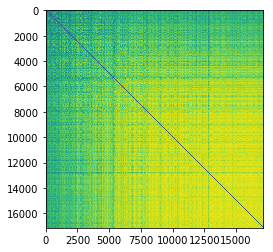

In [23]:
term_sim_w2v = metrics.pairwise.cosine_similarity(model.wv.vectors)
print('Term Similarity Matrix: (%i, %i)'%term_sim_w2v.shape)
plt.imshow(term_sim_w2v - sp.eye(term_sim_w2v.shape[0]))

###### can also run word2vec with just corpus words, but that's probably too little data 
I think this basically just grabs co-occurrence, but it seems that the vector arithmetics still "work"

In [24]:
corpus_terms
# get gensim model
model_reduced = gs.models.Word2Vec(corpus_terms, min_count=1, size=200, window=5, sg=1)
model_reduced.wv.most_similar(positive=['learning'], negative=['categorization'], topn=20)

[('difference threshold', 0.10300319641828537),
 ('perceptual binding', 0.06925730407238007),
 ('creative cognition', 0.026181504130363464),
 ('associative priming', 0.022323686629533768),
 ('pragmatic knowledge', 0.021260488778352737),
 ('auditory stream segregation', 0.021237503737211227),
 ('deep structure', 0.019191570580005646),
 ('contextual knowledge', 0.018078071996569633),
 ('language acquisition', 0.015674443915486336),
 ('conceptual category', 0.015331916511058807),
 ('cognitive heuristic', 0.014685381203889847),
 ('intention', 0.014341054484248161),
 ('error signal', 0.013484835624694824),
 ('critical period', 0.013463232666254044),
 ('meaning', 0.012907113879919052),
 ('lexicon', 0.012805495411157608),
 ('syntax', 0.012747826054692268),
 ('language processing', 0.01256839744746685),
 ('capacity limitation', 0.012268956750631332),
 ('neologism', 0.012181814759969711)]

# load pretrained GoogleNews word vectors

In [25]:
# this will take some time and memory
gnews_data_file = '/Users/rdgao/Documents/data/IdentityCrisis/GoogleNews-vectors-negative300.bin.gz'
model_gnews = gs.models.KeyedVectors.load_word2vec_format(gnews_data_file, binary=True)

In [26]:
# precompute subset indices
subset_inds = np.sort([model_gnews.index2word.index(t) for t in terms['Terms'] if t in model_gnews.index2word]) 

In [27]:
# full search has too many garbage words, need to prune to a smaller subset
# maybe only the cognitive terms, or even the whole vocab from cogsci
topn=10
positive = ['representation', 'memory']
#positive = ['memory','categorization']
negative = []
#negative = ['categorization']
# print('\n--- Search in whole corpus: ---')
# print_similarity(model_gnews.most_similar(positive=positive, negative=negative, topn=topn))

print('\n--- Search only the cognitive terms: ---')
print_similarity(most_similar_subset(model_gnews.index2word,subset_inds,model_gnews.vectors,positive,negative,topn))

positive = ['representation']
negative = ['memory']
print_similarity(most_similar_subset(model_gnews.index2word,subset_inds,model_gnews.vectors,positive,negative,topn))


--- Search only the cognitive terms: ---
Using precomputed subset indices...
----------------
Cosine Similiarty
---------------
0.7448: memory
0.3708: recognition
0.3191: consciousness
0.3128: perception
0.2843: communication
0.2830: logic
0.2817: encoding
0.2799: knowledge
0.2717: imagery
0.2717: reconsolidation
Using precomputed subset indices...
----------------
Cosine Similiarty
---------------
0.2130: action
0.1928: discrimination
0.1844: articulation
0.1688: deliberation
0.1540: prejudice
0.1452: coordination
0.1329: resource
0.1272: localization
0.1232: recognition
0.1188: expertise


# t-SNE on CogSci word2vec vectors

In [28]:
from sklearn.manifold import TSNE

In [29]:
# compute subset indices for cognitive terms
subset_inds_cs = np.sort([model.wv.index2word.index(t) for t in terms_merged if t in model.wv.index2word]) 
tsne_w2v = TSNE(n_components=2)
wv_2d = tsne_w2v.fit_transform(model.wv.vectors[subset_inds_cs,:])

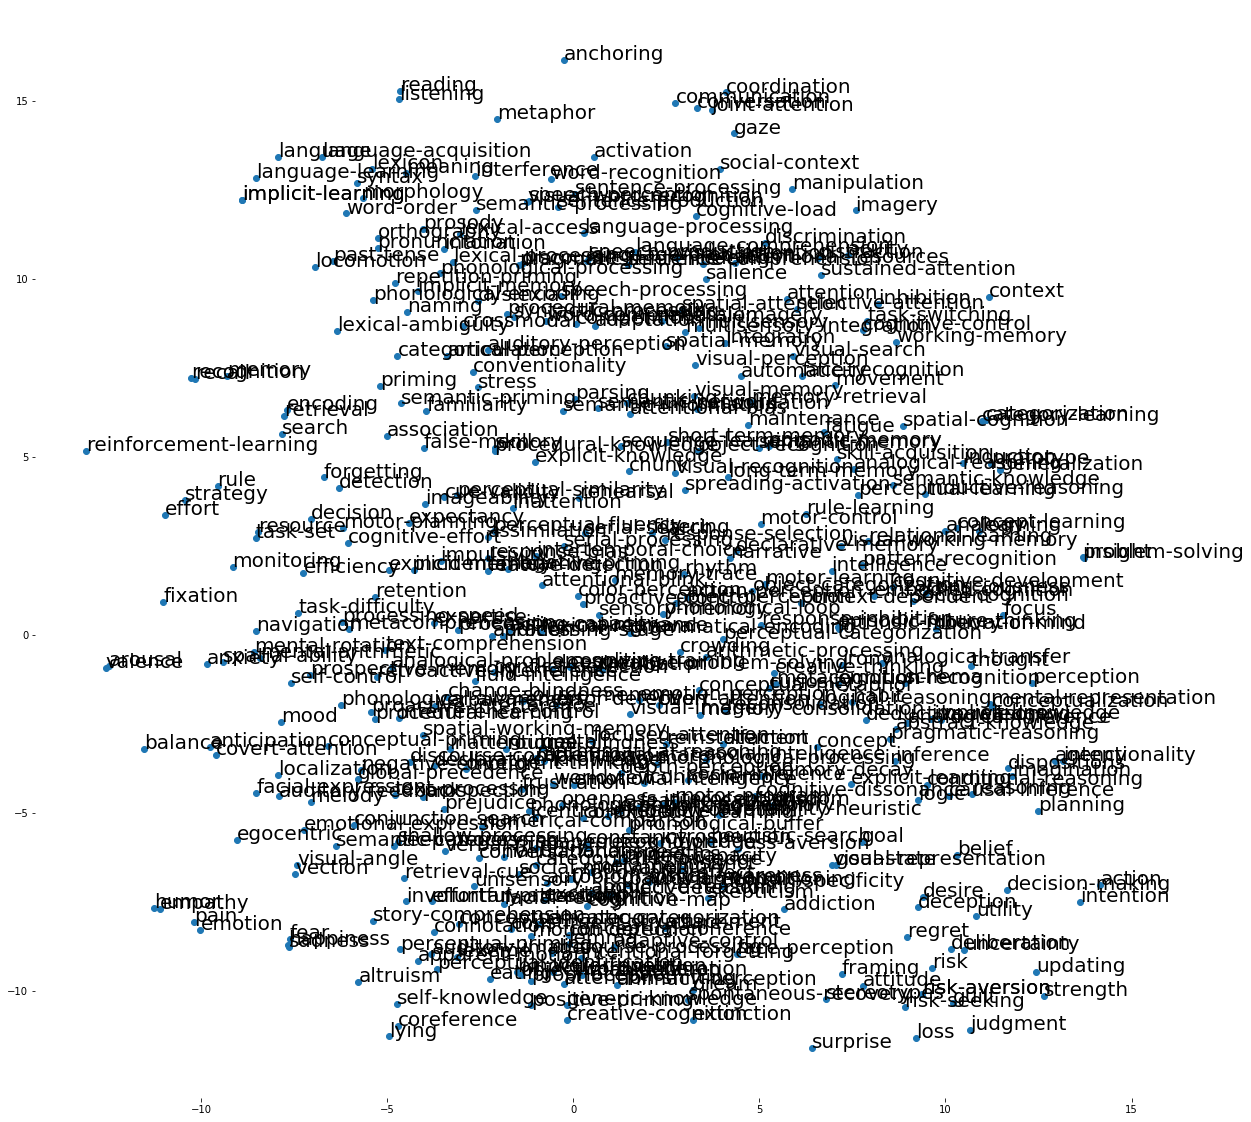

In [30]:
plt.figure(figsize=(20,20))
plt.scatter(wv_2d[:,0],wv_2d[:,1])
for i,w in enumerate(wv_2d):
    plt.annotate(model.wv.index2word[subset_inds_cs[i]], (w), fontsize=20, rotation=0)
    
plt.box('off')
#plt.xlim([2,4])